# Flex Net 2: Neural Network for Sound Parsing

### Preliminary Imports and Class Definitions

In [1]:
import soundfile as sf
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from os import listdir, getcwd, rename, remove
from os.path import isfile, join
from IPython.display import Audio

In [2]:
class SampleBank(tf.Module):
    def __init__(self, restricted_instruments = None, name=None):
        super(SampleBank, self).__init__(name=name)
        path = join(getcwd(), 'preprocessed_samples')
        files = [f for f in listdir(path) if isfile(join(path, f)) and f[0] != '.']
        samples = []
        for f in files:
            sample = {'instrument' : '_'.join(f.split('_')[:-1]),
                      'midi_number' : int(f.split('_')[-1][:-4]),
                      'filename' : join(path, f)}
            samples.append(sample)
        samples = sorted(samples, key=lambda x: (x['instrument'], x['midi_number']))
    
        instrument_names = set([s['instrument'] for s in samples])
        instruments = {}
        for inst in instrument_names:
            samples_for_inst = {s['midi_number'] : s['filename'] for s in samples if s['instrument'] == inst}
            instruments[inst] = {'samples' : samples_for_inst,
                                 'min_note' : min(samples_for_inst.keys()),
                                 'max_note' : max(samples_for_inst.keys())}
        if not restricted_instruments:
            restricted_instruments = [
                inst for inst in instrument_names
                if len(instruments[inst]['samples']) == 1 + (instruments[inst]['max_note'] - instruments[inst]['min_note'])
            ]
        soundfont = {}
        soundbank_ref = []
        k = 0
        for inst in restricted_instruments:
            print(inst, ' --- notes ',instruments[inst]['min_note'], ' through ', instruments[inst]['max_note'])
            soundfont[inst] = {}
            for i in range(128):
                if i in instruments[inst]['samples'].keys():
                    soundfont[inst][i] = (k, instruments[inst]['samples'][i])
                    soundbank_ref.append((inst, i))
                    k += 1
                else:
                    soundfont[inst][i] = None
        soundbank = [soundfont[x[0]][x[1]][1] for x in soundbank_ref]
        self.soundbank = soundbank
        self.soundbank_ref = soundbank_ref
        self.instruments = restricted_instruments
    
class Song(tf.Module):
    def __init__(self, sample_bank, sample_rate, length_in_samples, frame_length, frame_step, pulse_width):
        self.soundbank_ref = sample_bank.soundbank_ref
        self.instruments = sample_bank.instruments
        self.num_inst_samples = len(sample_bank.soundbank)
        self.sample_rate = sample_rate
        self.length_in_samples = length_in_samples
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.num_frames = ((length_in_samples - frame_length) // frame_step) + 1
        self.pulse_width = pulse_width
        padded_samples = []
        for sample_path in sample_bank.soundbank:
            sample = sf.read(sample_path)[0][:length_in_samples,0]
            padded_sample = np.zeros(length_in_samples)
            padded_sample[:sample.shape[0]] = sample
            padded_samples.append(padded_sample)
        self.padded_samples = tf.constant(padded_samples, dtype=tf.float32)
        self.output_signal = tf.Variable(tf.zeros([length_in_samples,], dtype=tf.float32))
        self.piano_roll = tf.Variable(tf.zeros([self.num_frames, self.num_inst_samples], dtype=tf.float32))

    # Play the current composition
    def play(self):
        return Audio(self.output_signal.numpy(), rate=self.sample_rate, autoplay=True)
    
    # Reset the current composition
    @tf.function
    def zero(self):
        self.output_signal = self.output_signal.assign(
            tf.zeros([self.length_in_samples,], dtype=tf.float32)
        )
        self.piano_roll = self.piano_roll.assign(
            tf.zeros([self.num_frames, self.num_inst_samples], dtype=tf.float32)
        )
    
    @tf.function
    def create(self, rate=0.0003):
        # Create Bernoulli generator for random note choice
        length = 3 * self.num_frames // 4
        probs = tf.concat([rate * tf.ones((length, self.num_inst_samples)),
                           tf.zeros((self.num_frames - length, self.num_inst_samples))],
                          axis=0)
        self.bernoulli_generator = tfp.distributions.Bernoulli(probs=probs, dtype=tf.float32)
        
        # Generate random notes
        random_notes = self.bernoulli_generator.sample()
        
        # Reset piano roll and output signal
        self.zero()
        
        # Add pulses to piano roll for each note
        for i in range(self.pulse_width):
            self.piano_roll = self.piano_roll.assign_add(
                tf.roll(random_notes, shift=i, axis=0)
            )
            
        # Write generated notes to output signal
        new_signals = tf.matmul(random_notes, self.padded_samples)
        for i in range(self.num_frames):
            self.output_signal = self.output_signal.assign_add(
                tf.roll(new_signals[i, :], shift=self.frame_length + i*self.frame_step, axis=0)
            )
        return self.output_signal, self.piano_roll

### Avant Garde Composer

Code to generate batches of random marimba compositions (with piano roll and corresponding audio)

In [3]:
class BatchGenerator():
    def __init__(self, batch_size, length_in_samples, pulse_width):
        self.song = Song(SampleBank(restricted_instruments=['Marimba_cord_ff']),
                         44100, length_in_samples, 1024, 512, pulse_width)
        self.batch_size = batch_size
        self.batch_output_signal = tf.Variable(
            tf.zeros([batch_size, length_in_samples], dtype=tf.float32)
        )
        self.batch_piano_roll = tf.Variable(
            tf.zeros([batch_size, self.song.num_frames, self.song.num_inst_samples], dtype=tf.float32)
        )
    
    def __call__(self):
        while True:
            for i in range(self.batch_size):
                output_signal, piano_roll = self.song.create()
                self.batch_output_signal = self.batch_output_signal[i].assign(output_signal)
                self.batch_piano_roll = self.batch_piano_roll[i].assign(piano_roll)
            hidden_state_0 = np.zeros([self.batch_size, 128])
            cell_state_0 = np.zeros([self.batch_size, 128])
            yield [self.batch_output_signal, hidden_state_0, cell_state_0], self.batch_piano_roll
        
batch_generator = BatchGenerator(10, 176400, 25)()
test_generator = BatchGenerator(1, 176400, 25)()

Marimba_cord_ff  --- notes  36  through  96
Marimba_cord_ff  --- notes  36  through  96


In [4]:
%%capture out

import matplotlib.pyplot as plt
from IPython.display import display, Audio

def show(arrays, aspect=1.0):
    fig, axes = plt.subplots(1,len(arrays), figsize=(10,10))
    for i, tensor_or_numpy_array in enumerate(arrays):
        if type(tensor_or_numpy_array) == np.ndarray:
            axes[i].imshow(tensor_or_numpy_array.T, aspect=(aspect), cmap='inferno')
        else:
            axes[i].imshow(tensor_or_numpy_array.numpy().T, aspect=(aspect), cmap='inferno')
    plt.close(fig)
    return display(fig)
    
def listen(tensor_or_numpy_array):
    if type(tensor_or_numpy_array) == np.ndarray:
        return Audio(tensor_or_numpy_array, rate=44100, autoplay=True)
    else:
        return Audio(tensor_or_numpy_array.numpy(), rate=44100, autoplay=True)

## Neural Network Classes

In [5]:
import tensorflow as tf
from keras.layers import Layer
from keras import Model, Input
from keras.layers import Layer, Concatenate, Dense, Activation, Dropout, LSTM, Lambda, Reshape
from keras.optimizers import Adam, SGD

class STFT(Layer):
    def __init__(self, frame_length=1024, frame_step=512, fft_length=1024):
        super(STFT, self).__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length

    def build(self, input_shape):  # Create the state of the layer (weights)
        pass

    def call(self, inputs):  # Defines the computation from inputs to outputs
        stfts = tf.signal.stft(inputs, frame_length=self.frame_length, frame_step=self.frame_step,
                       fft_length=self.fft_length)
        spectrograms = tf.abs(stfts)
        return spectrograms

Using TensorFlow backend.


In [6]:
def compute_fft_length(frame_length):
    fft_length = 1
    for i in range(100):
        if frame_length <= (2 ** (i+1)):
            fft_length *= 2
            break
    return fft_length

hidden_size = 128

def ConvLSTMModel(hidden_size, num_classes=61, frame_length=1024, frame_step=512, num_samples=176400, sample_rate=44100):
    
    # Compute fft_length (smallest power of 2 enclosing frame_length)
    fft_length = compute_fft_length(frame_length)
    # Compute number of fft bins
    fft_unique_bins = fft_length // 2 + 1
    # Compute number of frames
    num_frames = ((num_samples - frame_length) // frame_step) + 1
    
    LSTM_cell = LSTM(hidden_size, activation='tanh', return_state = True)
    Dense_cell = Dense(num_classes, activation='sigmoid')
    Reshapor = Reshape([1, num_classes])
    
    PCM = Input(shape=(num_samples,), name='pcm_input')    
    hidden_state_0 = Input(shape=(hidden_size,), name='hidden_state_0')
    cell_state_0 = Input(shape=(hidden_size,), name='cell_state_0')
    
    spec = STFT()(PCM)
    hidden_state = hidden_state_0
    cell_state = cell_state_0
    
    outputs = []
    for t in range(num_frames):
        spec_slice = Lambda(lambda x: x[:, t:t+1, :], output_shape=(1, 513))(spec)
        hidden_state, _, cell_state = LSTM_cell(spec_slice, initial_state=[hidden_state, cell_state])
        output = Dense_cell(hidden_state)
        outputs.append(Reshapor(output))
    
    result = Concatenate(axis=1)(outputs)
        
    model = Model(inputs=[PCM, hidden_state_0, cell_state_0], outputs=result)
    
    return model

model = ConvLSTMModel(hidden_size)

In [7]:
model.save_weights('initial_weights.h5')

In [ ]:
model.load_weights('initial_weights.h5')

In [8]:
optimizer = Adam(lr=0.0001)

model.compile(optimizer=optimizer, loss='cosine_similarity')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pcm_input (InputLayer)          (None, 176400)       0                                            
__________________________________________________________________________________________________
stft_1 (STFT)                   (None, 176400)       0           pcm_input[0][0]                  
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 513)       0           stft_1[0][0]                     
__________________________________________________________________________________________________
hidden_state_0 (InputLayer)     (None, 128)          0                                            
____________________________________________________________________________________________

                                                                 lstm_1[89][0]                    
                                                                 lstm_1[90][0]                    
                                                                 lstm_1[91][0]                    
                                                                 lstm_1[92][0]                    
                                                                 lstm_1[93][0]                    
                                                                 lstm_1[94][0]                    
                                                                 lstm_1[95][0]                    
                                                                 lstm_1[96][0]                    
                                                                 lstm_1[97][0]                    
                                                                 lstm_1[98][0]                    
          

In [9]:
import keras
from IPython.display import clear_output

class CustomCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        (batch_output_signal, hidden_state_0, cell_state_0), batch_piano_roll = test_generator.__next__()
        result = self.model.predict([batch_output_signal.numpy(), hidden_state_0, cell_state_0])
        error = batch_piano_roll[0].numpy() - result[0]
        show([batch_piano_roll[0].numpy(), result[0], error], aspect=5)
        

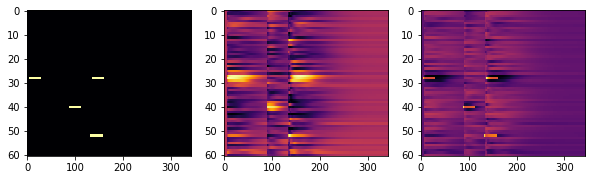

Epoch 35/5000
 7/10 [====================>.........] - ETA: 11s - loss: -0.0811

In [ ]:
model.fit_generator(batch_generator, steps_per_epoch=10, epochs=5000, callbacks=[CustomCallback()])

## Testing Performance Visually

In [ ]:
(batch_output_signal, hidden_state_0, cell_state_0), batch_piano_roll = test_generator.__next__()

In [ ]:
result = model.predict([batch_output_signal.numpy(), hidden_state_0, cell_state_0])

In [ ]:
type(batch_piano_roll.numpy())

In [ ]:
p = batch_piano_roll[0]
s = batch_output_signal

stfts = tf.signal.stft(s, frame_length=1024, frame_step=512,
                       fft_length=1024)
specs = tf.abs(stfts)[0]

In [ ]:
p

In [ ]:
specs

In [ ]:
show([p, p], aspect=5)
show([specs, specs], aspect=1)

In [ ]:
listen(s)